# **PyTorch Tutorial**

In this tutorial, we will explore how to train a neural network with PyTorch. (This tutorial was derived from a tutorial by Dr. Song Han at MIT.)

### Setup

We will then import a few libraries:

In [1]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.nn.functional as F

To ensure the reproducibility, we will control the seed of random generators:

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Data

In this tutorial, we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [3]:
transforms = {
  "train": Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
  ]),
  "test": ToTensor(),
}

dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

Files already downloaded and verified
Files already downloaded and verified


We can visualize a few images in the dataset and their corresponding class labels:

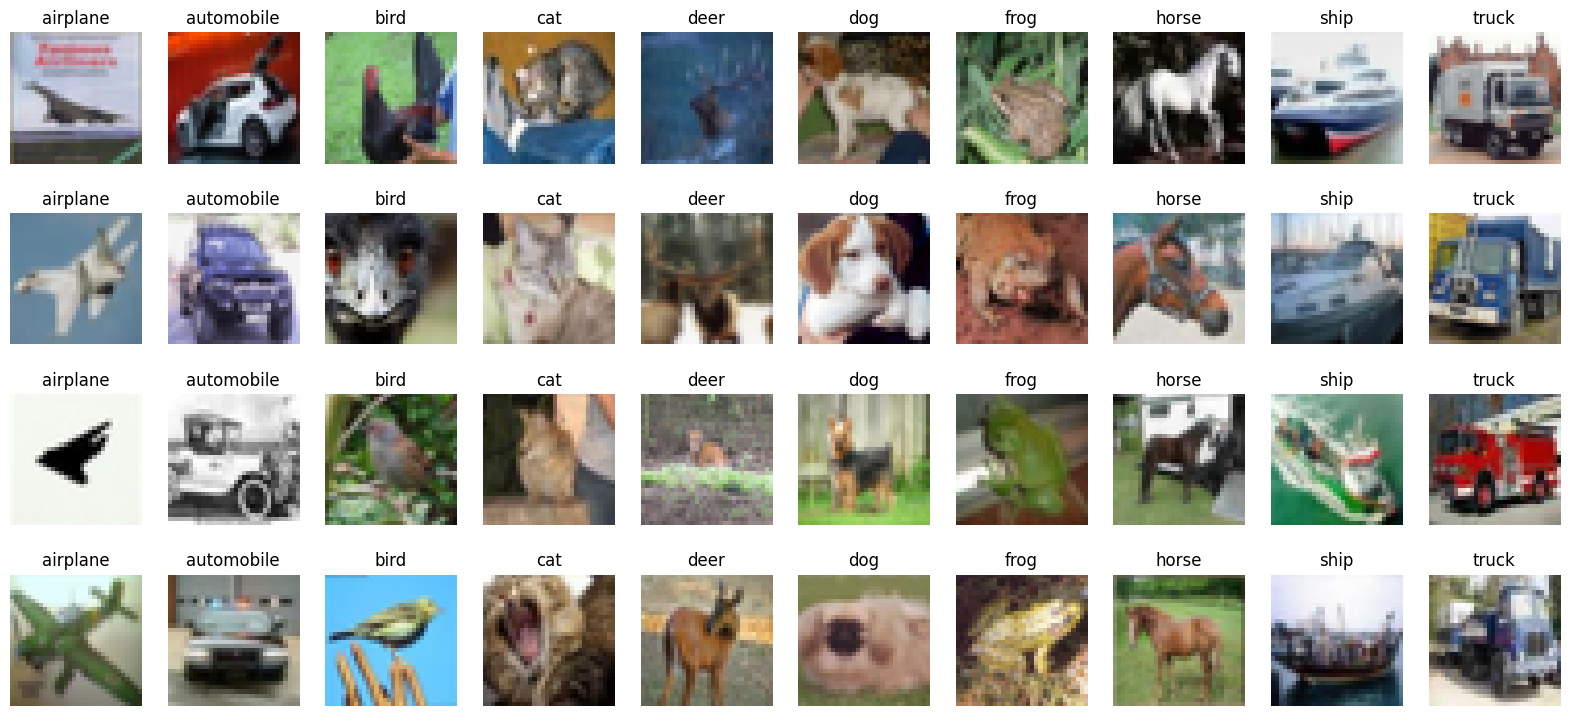

In [4]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

To train a neural network, we will need to feed data in batches. We create data loaders with batch size of 512:

In [5]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

We can print the data type and shape from the training data loader:

In [6]:
for inputs, targets in dataflow["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


### Model

In [7]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        # Fully connected layer (dense layer)
        self.fc1 = nn.Linear(in_features=32*8*8, out_features=128)
        # Output layer
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # Apply first convolution, followed by ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)
        # Apply second convolution, followed by ReLU and max pooling
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)
        # Flatten the output from the convolutional layers
        x = x.view(-1, 32*8*8)
        # Apply first fully connected layer followed by ReLU
        x = F.relu(self.fc1(x))
        # Apply output layer
        x = self.fc2(x)
        return x

model = SimpleCNN().cuda()

### Modifications Done : Modified the Model Defination.
- Added 2 more CNN layers (Total 4 CNN layers now)
- Added 1 Fully Connected Layer (Total 3 Fully connected layers now)
- Added 2 Dropout Layers
- And alongside added ReLU and MaxPooling layers.

In [7]:
#------------Modifications Done : Modified the Model Defination by adding 2 more CNN layers, 1 Fully Connected Layer, 2 Dropout layers and alongside added ReLU and MaxPooling layers.-----------------------------
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Fully connected layer (dense layer)
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=512)  # Adjusted input size
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        # Output layer
        self.fc3 = nn.Linear(in_features=256, out_features=10)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply first convolution, followed by ReLU, batch norm, and max pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Apply second convolution, followed by ReLU, batch norm, and max pooling
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Apply third convolution, followed by ReLU, batch norm, and max pooling
        x = F.relu(self.bn3(self.conv3(x)))

        # Apply fourth convolution, followed by ReLU, batch norm, and max pooling
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)  # Use one less pooling layer here to maintain a larger spatial dimension

        # Flatten the output from the convolutional layers
        x = x.view(-1, 256*4*4)  # Adjusted flattening size

        # Apply first fully connected layer followed by ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Apply second fully connected layer followed by ReLU and dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Apply output layer
        x = self.fc3(x)

        return x

model = SimpleCNN().cuda()

After the feature map is pooled, its classifier predicts the final output with a linear layer:

### Optimization

As we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [8]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum):

In [9]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

### Modifications Done : Using Adam Optimizer.
- Using Adam Optimizer instead of SGD as it provides slightly better performance in terms of accuracy.
- Using Adam Optimizer with `lr=0.005` and `weight_decay=5e-4`

In [9]:
# Using Adam Optimizer
#------------  Modifications Done : Using Adam Optimizer ----------------------
optimizer = Adam(
    model.parameters(),
    lr=0.005,
    weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

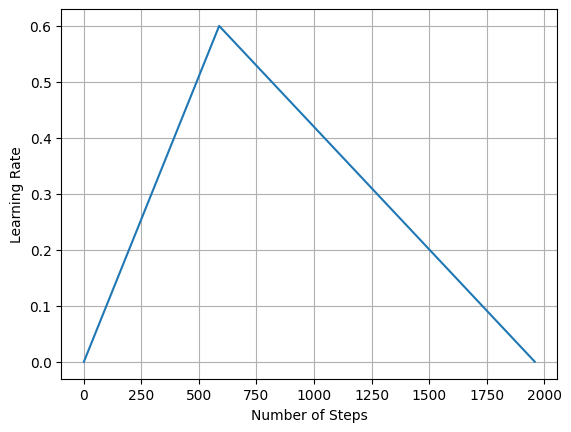

In [10]:
num_epochs = 20
steps_per_epoch = len(dataflow["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.6 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

### Training

We first define the training function that optimizes the model for one epoch (*i.e.*, a pass over the training set):

In [11]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)

    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

We then define the evaluation function that calculates the metric (*i.e.*, accuracy in our case) on the test set:

In [12]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [13]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataflow["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataflow["test"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: 37.279998779296875


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: 39.30999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: 56.769996643066406


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: 49.689998626708984


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: 60.45000076293945


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: 65.20000457763672


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: 64.08000183105469


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: 64.4000015258789


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: 70.6500015258789


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: 70.22000122070312


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: 64.43000030517578


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: 78.56999969482422


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: 80.42999267578125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: 80.42999267578125


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: 80.68999481201172


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: 79.5999984741211


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: 82.40999603271484


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: 85.5999984741211


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: 85.77999877929688


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 86.98999786376953


### Visualization

We can visualize the model's prediction to see how the model truly performs:

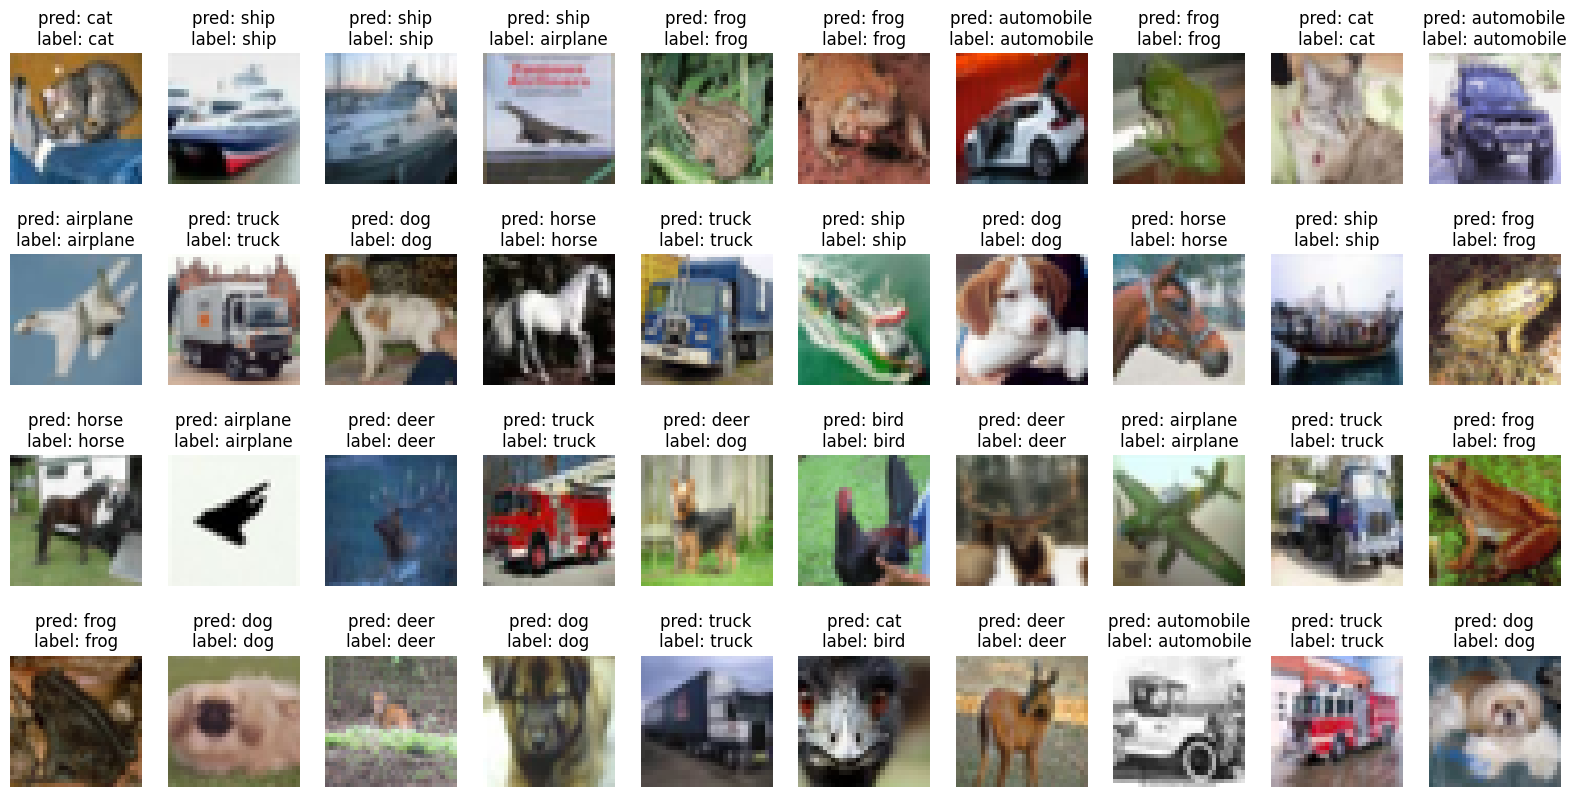

In [16]:
plt.figure(figsize=(20, 10))
for index in range(40):
  image, label = dataset["test"][index]

  # Model inference
  model.eval()
  with torch.inference_mode():
    pred = model(image.unsqueeze(dim=0).cuda())
    pred = pred.argmax(dim=1)

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class indices to class names
  pred = dataset["test"].classes[pred]
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(f"pred: {pred}" + "\n" + f"label: {label}")
  plt.axis("off")
plt.show()